**Installing and importing the necaessary packages**

In [69]:
pip install arch

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model

**Data sourcing**

In [71]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GOOGLE.csv')

In [72]:
df = data.copy()

In [22]:
df.head(),df.tail()

(         Date      Open      High       Low     Close     Volume
 0  2004-08-19  2.502503  2.604104  2.401401  2.511011  893181924
 1  2004-08-20  2.527778  2.729730  2.515015  2.710460  456686856
 2  2004-08-23  2.771522  2.839840  2.728979  2.737738  365122512
 3  2004-08-24  2.783784  2.792793  2.591842  2.624374  304946748
 4  2004-08-25  2.626627  2.702703  2.599600  2.652653  183772044,
             Date        Open        High         Low       Close    Volume
 4712  2023-05-09  108.389999  110.150002  107.190002  107.349998  36360100
 4713  2023-05-10  107.970001  112.940002  107.930000  111.750000  63153400
 4714  2023-05-11  115.400002  117.919998  114.410004  116.570000  78900000
 4715  2023-05-12  116.680000  118.029999  116.110001  117.510002  41073800
 4716  2023-05-15  116.110001  118.480003  116.010002  116.510002  36226100)

**Data preprocessing**

In [73]:
df.set_index('Date',inplace=True)
df.index = pd.to_datetime(df.index)
df.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512


In [74]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

We'll set the frequency to business days as this is when the stock market operates.
This will create some null values which we will impute.

In [75]:
df = df.asfreq('b')

In [76]:
df.isna().sum()

Open      171
High      171
Low       171
Close     171
Volume    171
dtype: int64

In [77]:
df = df.asfreq('b')
df = df.fillna(method='ffill')
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [78]:
price = df[['Close']]
price.head(3)

,Close
Date,
2004-08-19,2.511011
2004-08-20,2.710460
2004-08-23,2.737738


**Plotting the Closing Prices**

Text(0, 0.5, 'Closing Price')

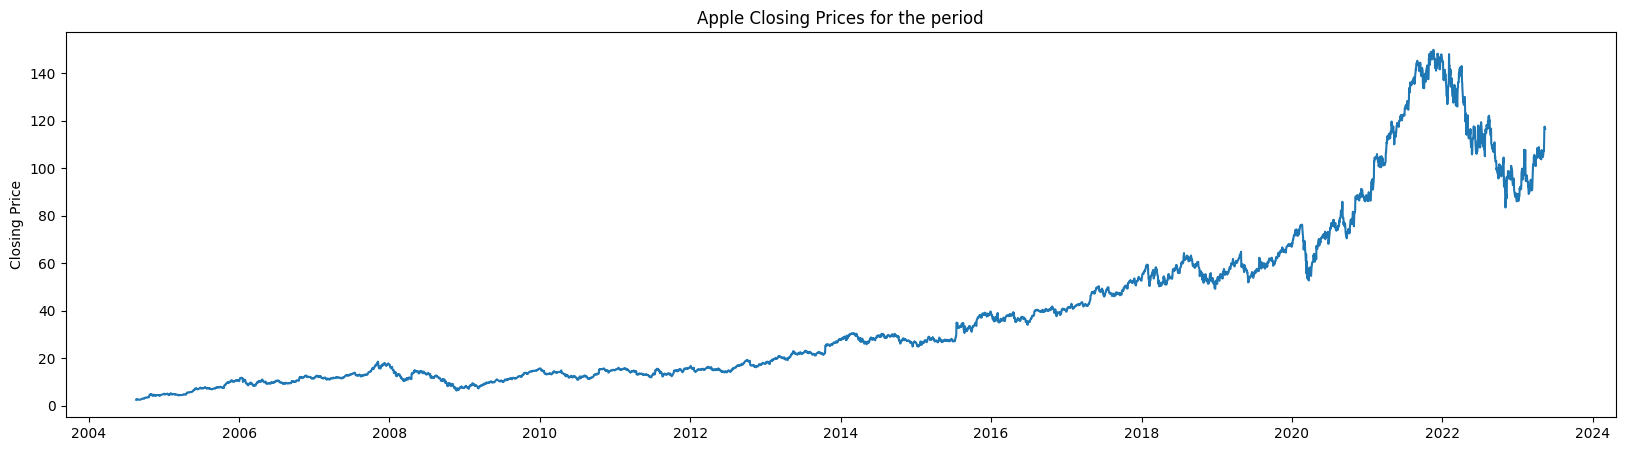

In [79]:
plt.figure(figsize=(20,5))
plt.plot(price)
plt.title('Apple Closing Prices for the period')
plt.ylabel('Closing Price')

In [82]:
returns = price['Close'].pct_change().mul(100).dropna()

**Plotting the returns**

Text(0.5, 1.0, 'Volatility over the entire period')

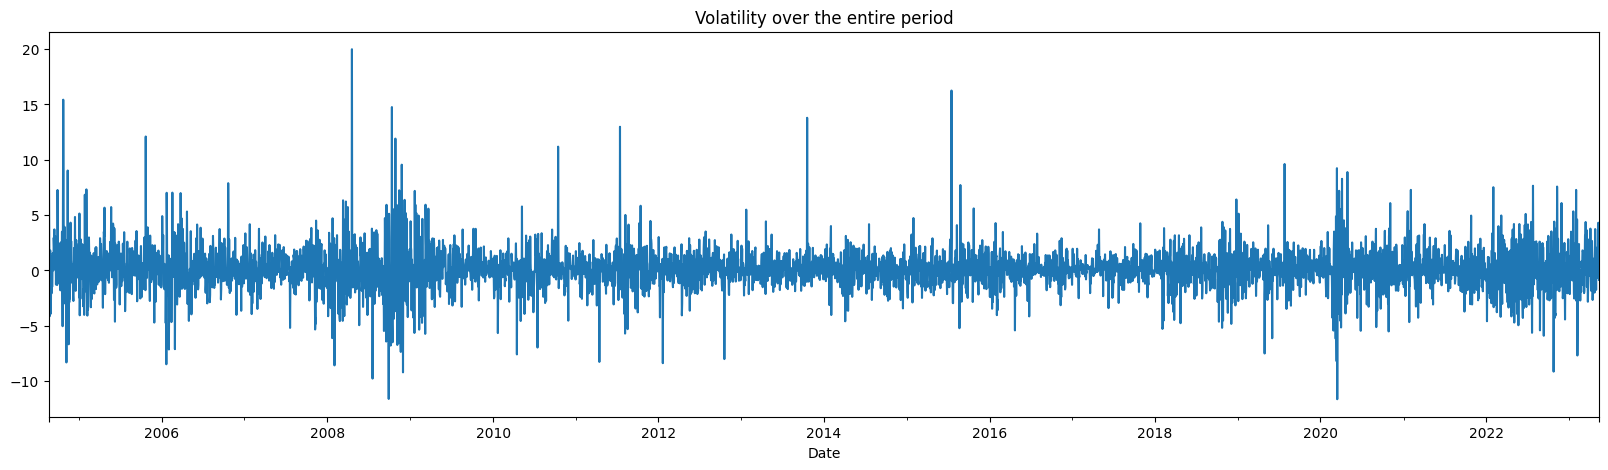

In [83]:
plt.figure(figsize=(20,5))
returns.plot()
plt.title('Volatility over the entire period')

**Seasonality Check**

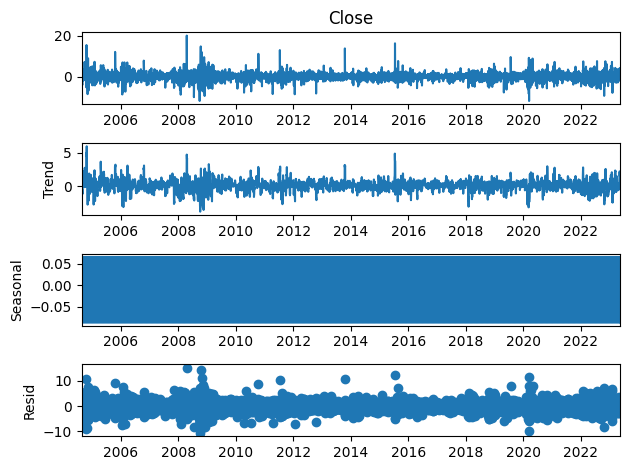

In [145]:
seas = seasonal_decompose(returns)
seas.plot()
plt.show()

We observe no visibilty within our data.

In [84]:
sts.adfuller(returns)

(-30.02952069386892,
 0.0,
 5,
 4881,
 {'1%': -3.4316904512156343,
  '5%': -2.862132331310355,
  '10%': -2.5670852992208206},
 20016.27160447636)

Text(0.5, 1.0, 'PACF')

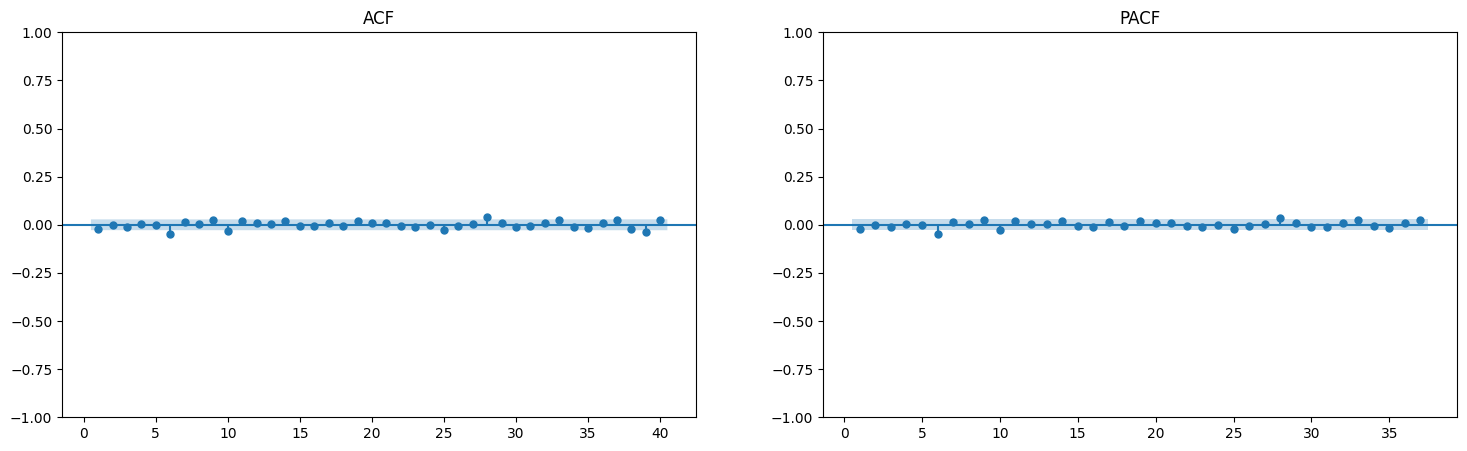

In [85]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sgt.plot_acf(returns, zero = False,ax=ax[0],lags=40)
ax[0].set_title('ACF')
sgt.plot_pacf(returns, zero = False,ax=ax[1],method='ywm')
ax[1].set_title('PACF')

**Insights**:
We still can't decipher the p and q values from the returns dataset hence we go ahead and square the returns (Increase the diiferencing level)

Text(0.5, 1.0, 'PACF')

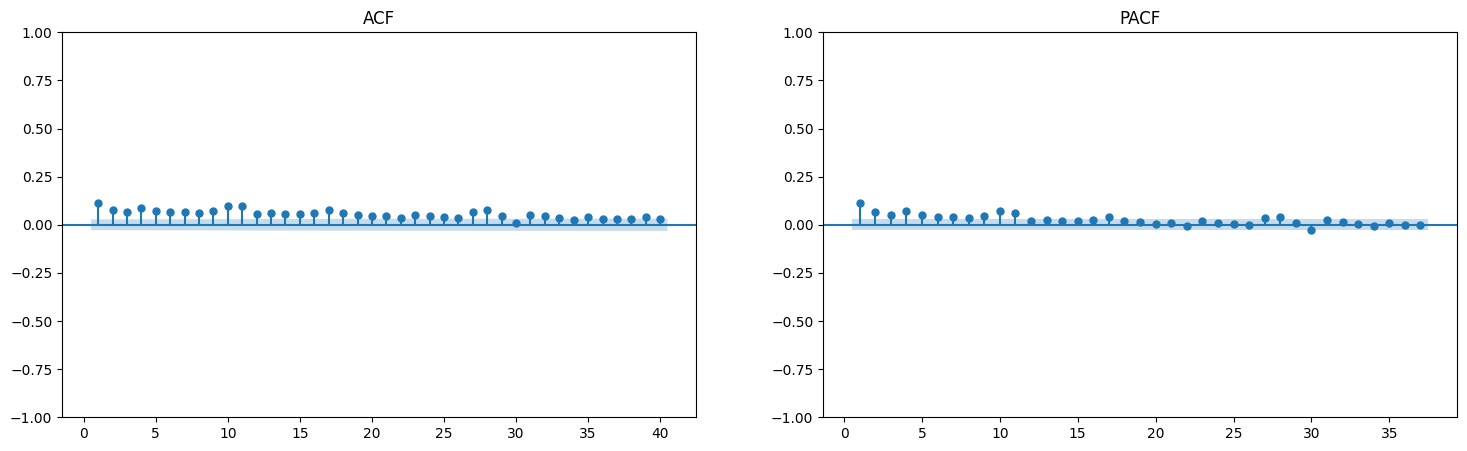

In [86]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sgt.plot_acf((returns **2), zero = False,ax=ax[0],lags=40)
ax[0].set_title('ACF')
sgt.plot_pacf((returns **2), zero = False,ax=ax[1],method='ywm')
ax[1].set_title('PACF')

We can now observe some wicks above the significance level and can select some values to model with.
It appears the correlation decays to the 3rd wick before increasing again.
We'll therefore try values between 1 and 3 and select the best performing.

**Splitting the data into train and test sets**

In [90]:
size = int(len(returns)*0.95)

train_ret = returns[:size]
test_ret = returns[size:]

train_ret.shape,test_ret.shape

((4642,), (245,))

In [91]:
split_date = returns.iloc[size:].index
split_date

DatetimeIndex(['2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16',
               '2022-06-17', '2022-06-20',
               ...
               '2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
               '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
               '2023-05-12', '2023-05-15'],
              dtype='datetime64[ns]', name='Date', length=245, freq='B')

In [103]:
model = arch_model(train_ret,p=3,q=3)
res = model.fit()
res.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 18938.249239075958
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1806521.9045152601
Iteration:      3,   Func. Count:     35,   Neg. LLF: 10682.475518591153
Iteration:      4,   Func. Count:     46,   Neg. LLF: 9279.944072215214
Iteration:      5,   Func. Count:     56,   Neg. LLF: 9142.298796729998
Iteration:      6,   Func. Count:     66,   Neg. LLF: 9188.631419547986
Iteration:      7,   Func. Count:     76,   Neg. LLF: 9093.4457888576
Iteration:      8,   Func. Count:     86,   Neg. LLF: 9160.707430376864
Iteration:      9,   Func. Count:     96,   Neg. LLF: 9090.179905589368
Iteration:     10,   Func. Count:    106,   Neg. LLF: 9192.179273632722
Iteration:     11,   Func. Count:    117,   Neg. LLF: 9089.421244725228
Iteration:     12,   Func. Count:    127,   Neg. LLF: 9083.547712192267
Iteration:     13,   Func. Count:    137,   Neg. LLF: 9084.996474784355
Iteration:     14,   Func. Count:    147,   Neg. LLF: 9081.4486

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9079.45
Distribution:                  Normal   AIC:                           18174.9
Method:            Maximum Likelihood   BIC:                           18226.4
                                        No. Observations:                 4642
Date:                Thu, Jun 29 2023   Df Residuals:                     4641
Time:                        12:43:58   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1102  2.652e-02      4.154  3.260e-05 [5.821e-02,  0.162]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3123      0.214      1.460      0.144      [ -0.107,  0.731]
alpha[1]       0.1046  7.767e-02      1.346      0.178   [-4.765e-02,  0.257]
alpha[2]       0.0710      0.167      0.426      0.670      [ -0.256,  0.398]
alpha[3]       0.0305  3.087e-02      0.987      0.324 [-3.004e-02,9.098e-02]
beta[1]    6.5534e-03      0.739  8.874e-03      0.993      [ -1.441,  1.454]
beta[2]    3.0875e-15      0.497  6.211e-15      1.000      [ -0.974,  0.974]
beta[3]        0.7040      0.145      4.868  1.127e-06      [  0.421,  0.987]
=============================================================================

Covariance estimator: robust
"""

**Insights:**


*   The coeficients for alpha show no significance at any level.
*   The beta[3] coefficient show some significance ie (<= 0.05).

This implies that we use a simpler model.



In [107]:
model = arch_model(train_ret,p=1,q=3)
res = model.fit()
res.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 27938.50253481621
Iteration:      2,   Func. Count:     19,   Neg. LLF: 22918.00009424815
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1037185131.4287697
Iteration:      4,   Func. Count:     37,   Neg. LLF: 165557.69076375364
Iteration:      5,   Func. Count:     45,   Neg. LLF: 9257.787712532676
Iteration:      6,   Func. Count:     53,   Neg. LLF: 9113.198300538854
Iteration:      7,   Func. Count:     61,   Neg. LLF: 10513.694017310512
Iteration:      8,   Func. Count:     69,   Neg. LLF: 9109.298848137572
Iteration:      9,   Func. Count:     77,   Neg. LLF: 9084.243348733537
Iteration:     10,   Func. Count:     85,   Neg. LLF: 9081.100538562121
Iteration:     11,   Func. Count:     92,   Neg. LLF: 9081.093393884203
Iteration:     12,   Func. Count:     99,   Neg. LLF: 9081.092369284504
Iteration:     13,   Func. Count:    106,   Neg. LLF: 9081.091205730207
Iteration:     14,   Func. Count:    113,   Neg. LLF: 9081.09

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9081.09
Distribution:                  Normal   AIC:                           18174.2
Method:            Maximum Likelihood   BIC:                           18212.8
                                        No. Observations:                 4642
Date:                Thu, Jun 29 2023   Df Residuals:                     4641
Time:                        12:46:16   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1128  2.699e-02      4.180  2.913e-05 [5.993e-02,  0.166]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1831  9.412e-02      1.945  5.179e-02 [-1.416e-03,  0.368]
alpha[1]       0.1276  5.008e-02      2.549  1.081e-02  [2.949e-02,  0.226]
beta[1]        0.4166      0.252      1.655  9.791e-02 [-7.674e-02,  0.910]
beta[2]    8.2875e-15      0.315  2.630e-14      1.000    [ -0.618,  0.618]
beta[3]        0.4068      0.310      1.312      0.189    [ -0.201,  1.014]
===========================================================================

Covariance estimator: robust
"""

**Insights:**


*   The coefficient for alpha is now significant (<=0.05).
*   Beta coefficients at levels 2 and 3 show no significance implying we reduce the number of lags to achieve complete significance.



In [108]:
model = arch_model(train_ret,p=1,q=1)
res = model.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 85123076770.94849
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30164.826888760515
Iteration:      3,   Func. Count:     24,   Neg. LLF: 11050.460496779411
Iteration:      4,   Func. Count:     31,   Neg. LLF: 9839.62571647619
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9281.18195020147
Iteration:      6,   Func. Count:     45,   Neg. LLF: 9085.29059763591
Iteration:      7,   Func. Count:     50,   Neg. LLF: 9085.256874024224
Iteration:      8,   Func. Count:     55,   Neg. LLF: 9085.244784794811
Iteration:      9,   Func. Count:     60,   Neg. LLF: 9085.243871570947
Iteration:     10,   Func. Count:     65,   Neg. LLF: 9085.243793390677
Iteration:     11,   Func. Count:     70,   Neg. LLF: 9085.243791992936
Iteration:     12,   Func. Count:     74,   Neg. LLF: 9085.243791993467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9085.243791992936
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9085.24
Distribution:                  Normal   AIC:                           18178.5
Method:            Maximum Likelihood   BIC:                           18204.3
                                        No. Observations:                 4642
Date:                Thu, Jun 29 2023   Df Residuals:                     4641
Time:                        12:46:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1069  2.425e-02      4.408  1.046e-05 [5.935e-02,  0.154]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1244  6.286e-02      1.978  4.789e-02 [1.155e-03,  0.248]
alpha[1]       0.0852  3.181e-02      2.678  7.415e-03 [2.283e-02,  0.148]
beta[1]        0.8824  4.362e-02     20.229  5.431e-91   [  0.797,  0.968]
==========================================================================

Covariance estimator: robust
"""

We can now observe all coefficients having significance at p and q values of 1,1.

In [110]:
garch = arch_model(train_ret, mean='zero', vol='GARCH',p=1, q=1).fit()
garch.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 115295815.27219823
Iteration:      2,   Func. Count:     11,   Neg. LLF: 9944.018866713795
Iteration:      3,   Func. Count:     18,   Neg. LLF: 9686.679788340141
Iteration:      4,   Func. Count:     25,   Neg. LLF: 9502.68523796995
Iteration:      5,   Func. Count:     30,   Neg. LLF: 9098.228328486617
Iteration:      6,   Func. Count:     35,   Neg. LLF: 9095.975234664013
Iteration:      7,   Func. Count:     39,   Neg. LLF: 9095.972593963488
Iteration:      8,   Func. Count:     43,   Neg. LLF: 9095.972566461654
Iteration:      9,   Func. Count:     46,   Neg. LLF: 9095.972566459852
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9095.972566461654
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9095.97
Distribution:                  Normal   AIC:                           18197.9
Method:            Maximum Likelihood   BIC:                           18217.3
                                        No. Observations:                 4642
Date:                Thu, Jun 29 2023   Df Residuals:                     4642
Time:                        12:47:25   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1196  6.082e-02      1.966  4.929e-02 [3.698e-04,  0.239]
alpha[1]       0.0830  3.073e-02      2.700  6.927e-03 [2.275e-02,  0.143]
beta[1]        0.8860  4.212e-02     21.035  3.148e-98   [  0.803,  0.969]
==========================================================================

Covariance estimator: robust
"""

In [119]:
pred = garch.forecast(horizon = len(test_ret),reindex=True)

In [120]:
for i in pred.variance.values:
  fc = pd.Series(i, index=split_date)


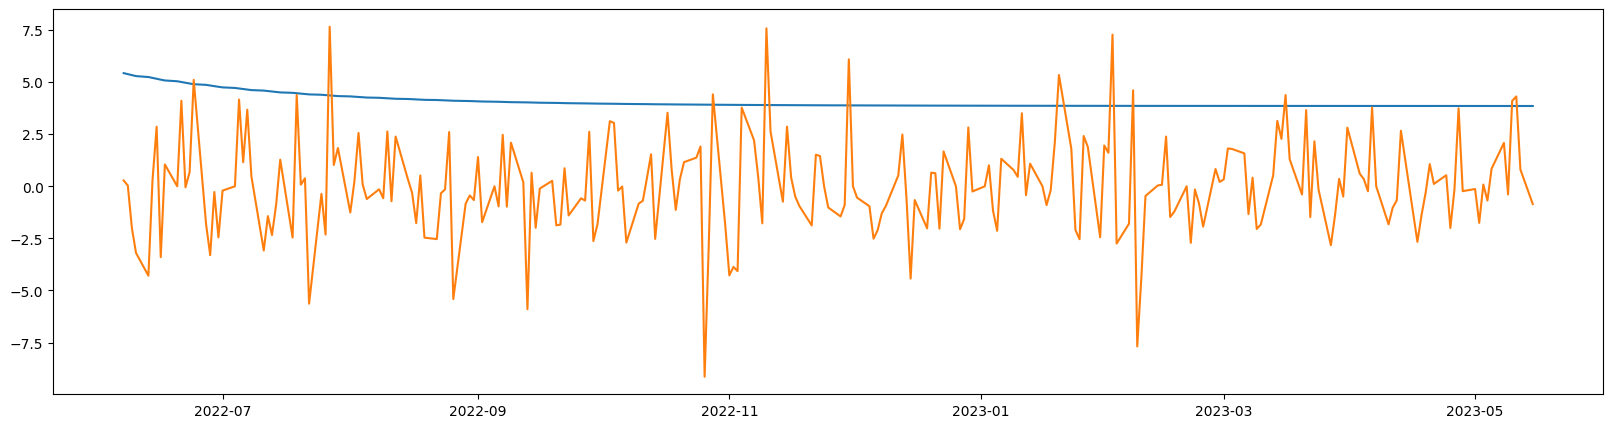

In [121]:
plt.figure(figsize=(20,5))
plt.plot(fc)
plt.plot(test_ret)

**Using Rolling Window**

In [141]:
rolling_pred = []
test_size = len(test_ret)

for i in range(test_size):
    train = train_ret[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=True)
    rolling_pred.append(pred.variance.values[-1,:][0])

In [142]:
ret_pred = pd.Series(rolling_pred,index = split_date)

Text(0.5, 1.0, 'Actual vs predicted volatility')

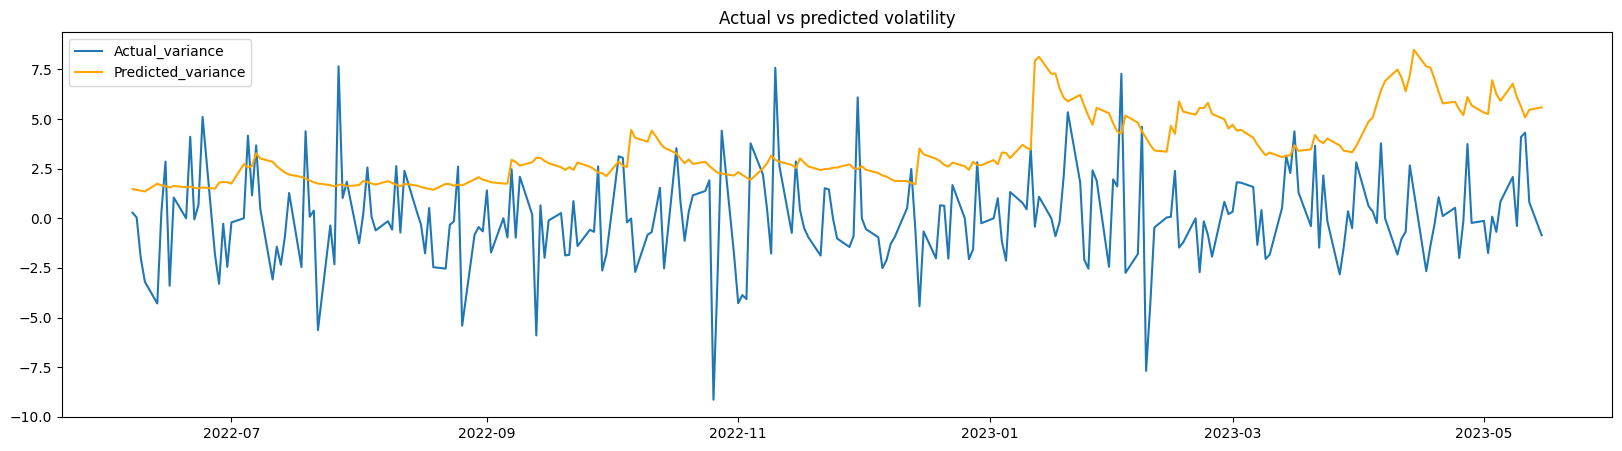

In [143]:
plt.figure(figsize=(20,5))
plt.plot(test_ret,label = 'Actual_variance')
plt.plot(ret_pred,color='orange',label = 'Predicted_variance')
plt.legend()
plt.title('Actual vs predicted volatility')

In [109]:
# looping through subsequent values of p and q to get the combination that gives the best bic

# bic_garch = []

# for p in range(1, 5):
#     for q in range(1, 5):
#         garch = arch_model(train_ret, mean='zero',vol='GARCH', p=p, o=0, q=q).fit()
#         bic_garch.append(garch.bic)
#         if garch.bic == np.min(bic_garch):
#             best_param = p, q